# As Unsupervised Problem

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
from nltk.corpus import gutenberg
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# read data as paragraphs
emma = gutenberg.paras('austen-emma.txt')
emma_paras = []
for paragraph in emma:
    para = paragraph[0]
    para = [re.sub(r'--', '', word) for word in para]
    emma_paras.append(' '.join(para))

In [2]:
X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

# Apply vectorizer
emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

# Train vs. Test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


# Reshapes the vectorizer output to be readable
X_train_tfidf_csr = X_train_tfidf.tocsr()

# num of paragraphs
n = X_train_tfidf_csr.shape[0]

# 1 dictionary per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

# list of features
terms = vectorizer.get_feature_names()

# for each paragraph, list feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# log base 2 of 1 is 0
# tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[4])
print('Tf_idf vector:', tfidf_bypara[4])

Number of features: 1948
Original sentence: Emma smiled and answered " My visit was of use to the nervous part of her complaint , I hope ; but not even I can charm away a sore throat ; it is a most severe cold indeed .
Tf_idf vector: {'charm': 0.3222847211538923, 'complaint': 0.3222847211538923, 'answered': 0.2606939950302343, 'throat': 0.31020117766846184, 'sore': 0.31020117766846184, 'cold': 0.24942607165925315, 'nervous': 0.30082845317847623, 'use': 0.25758122927286636, 'severe': 0.31020117766846184, 'hope': 0.20166522850432286, 'smiled': 0.2640560381725886, 'away': 0.21244826203338835, 'visit': 0.2203117301686013, 'emma': 0.1118224252247886}


In [3]:
# SVD data reducer – reduce feature space from 1379 to 130.
svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:", total_variance * 100)

# Types of paragraphs our solution considers similar, for first 5 identified topics
paras_by_component = pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 45.204886720938035
Component 0:
" Oh !     0.999292
" Oh !     0.999292
" Oh !     0.999292
Oh !       0.999292
" Oh !     0.999292
" Oh !"    0.999292
" Oh !     0.999292
" Oh !     0.999292
" Oh !     0.999292
" Oh !     0.999292
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.635571
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.575485
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .                         0.562441
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but 

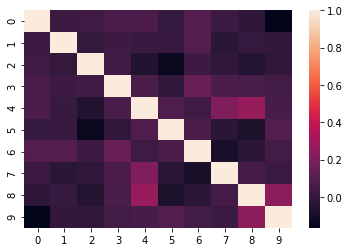

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [4]:
def compute_similarity():
    # Compute document similarity using LSA components
    similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)

    # For 1st 10 sentences
    sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]

    ax = sns.heatmap(sim_matrix,yticklabels=range(10))
    plt.show()

    # Generate key for plot
    print('Key:')
    for i in range(10):
        print(i, sim_matrix.index[i])

compute_similarity()

## Drill 0: Test set
Apply our LSA model to the test set. Does it identify similar sentences for components 0 through 4?

Remember, you will use the same model, only with the test set data.  Don't fit a new model by mistake!

In [5]:
X_test_lsa = lsa.transform(X_test_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:", total_variance * 100)

paras_by_component = pd.DataFrame(X_test_lsa, index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 45.204886720938035
Component 0:
" Oh !       0.999292
" Oh !       0.999292
" Oh !       0.999292
" Oh !       0.999292
" Oh !       0.999292
" Oh !       0.999292
" Oh !       0.999292
" Oh no !    0.999292
" Oh !       0.999292
" Oh !       0.999292
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.676365
Frank turned instantly to Emma , to claim her former promise ; and boasted himself an engaged man , which his father looked his most perfect approbation of  and it then appeared that Mrs . Weston was wanting _him_ to dan

## Drill 1: Tweaking tf-idf
Go back up to the code where we originally translated the text from words to numbers. There are a lot of decision-points here, from the stop list to the thresholds for inclusion and exclusion, and many others as well. We also didn't integrate spaCy, and so don't have info on lemmas or Named Entities. 

Change things up a few times and see how that affects the results of the LSA. 

In [6]:
X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.4, # drop words that occur in more than half the paragraphs
                             min_df=6, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, # convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,# we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', # Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True # Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)

# Reshapes vectorizer output to be readable
X_train_tfidf_csr = X_train_tfidf.tocsr()

# num of paragraphs
n = X_train_tfidf_csr.shape[0]

# 1 dictionary per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

# list of features
terms = vectorizer.get_feature_names()

# for each paragraph, list feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# log base 2 of 1 is 0
# tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[4])
print('Tf_idf vector:', tfidf_bypara[4])

Number of features: 670
Original sentence: Emma smiled and answered " My visit was of use to the nervous part of her complaint , I hope ; but not even I can charm away a sore throat ; it is a most severe cold indeed .
Tf_idf vector: {'answered': 0.40560853492572185, 'cold': 0.3880769999564222, 'use': 0.4007654453936191, 'hope': 0.3137668662817215, 'smiled': 0.41083947011918204, 'away': 0.33054397091457643, 'visit': 0.34277858256870725, 'emma': 0.1739822586324144}


In [7]:
# SVD data reducer – reduce feature space from 1379 to 130.
svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:", total_variance * 100)

# Types of paragraphs our solution considers similar, for first 5 identified topics
paras_by_component = pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 58.304081065437565
Component 0:
" Oh !    0.999011
" Oh !    0.999011
Oh !      0.999011
" Oh !    0.999011
" Oh !    0.999011
" Oh !    0.999011
" Oh !    0.999011
" Oh !    0.999011
" Oh !    0.999011
" Oh !    0.999011
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.700455
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.631831
Mr . Knightley might quarrel with her , but Emma could not quarrel with herself .                                                                                           0.610052
" There were misunderstandings between them , Emma ; he said so expressly .                                                                              

In [8]:
X_test_lsa = lsa.transform(X_test_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:", total_variance * 100)

paras_by_component = pd.DataFrame(X_test_lsa, index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 58.304081065437565
Component 0:
" Oh !     0.999009
" Oh !     0.999009
" Oh !     0.999009
" Oh !     0.999009
" Oh !     0.999009
" Oh !"    0.999009
" Oh !     0.999009
" Oh !     0.999009
" Oh !     0.999009
" Oh !     0.999009
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.659765
" Well ," said Emma , " there is no disputing about taste . At least you admire her except her complexion ."                                                                                                                                    

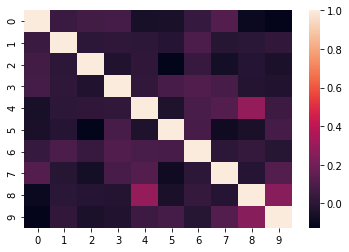

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [9]:
compute_similarity()